In [1]:
import numpy as np
import src.models.helpers as mh
import plotly.graph_objects as go
import src.modelling_fev1.uecfev1 as uecfev1
import src.data.breathe_data as bd
import plotly.express as px
import pandas as pd
import src.data.helpers as dh

In [2]:
df = bd.load_meas_from_excel("BR_O2_FEV1_FEF2575_conservative_smoothing_with_idx")

## Pick std gauss from the FEV1 variability study (msc thesis)

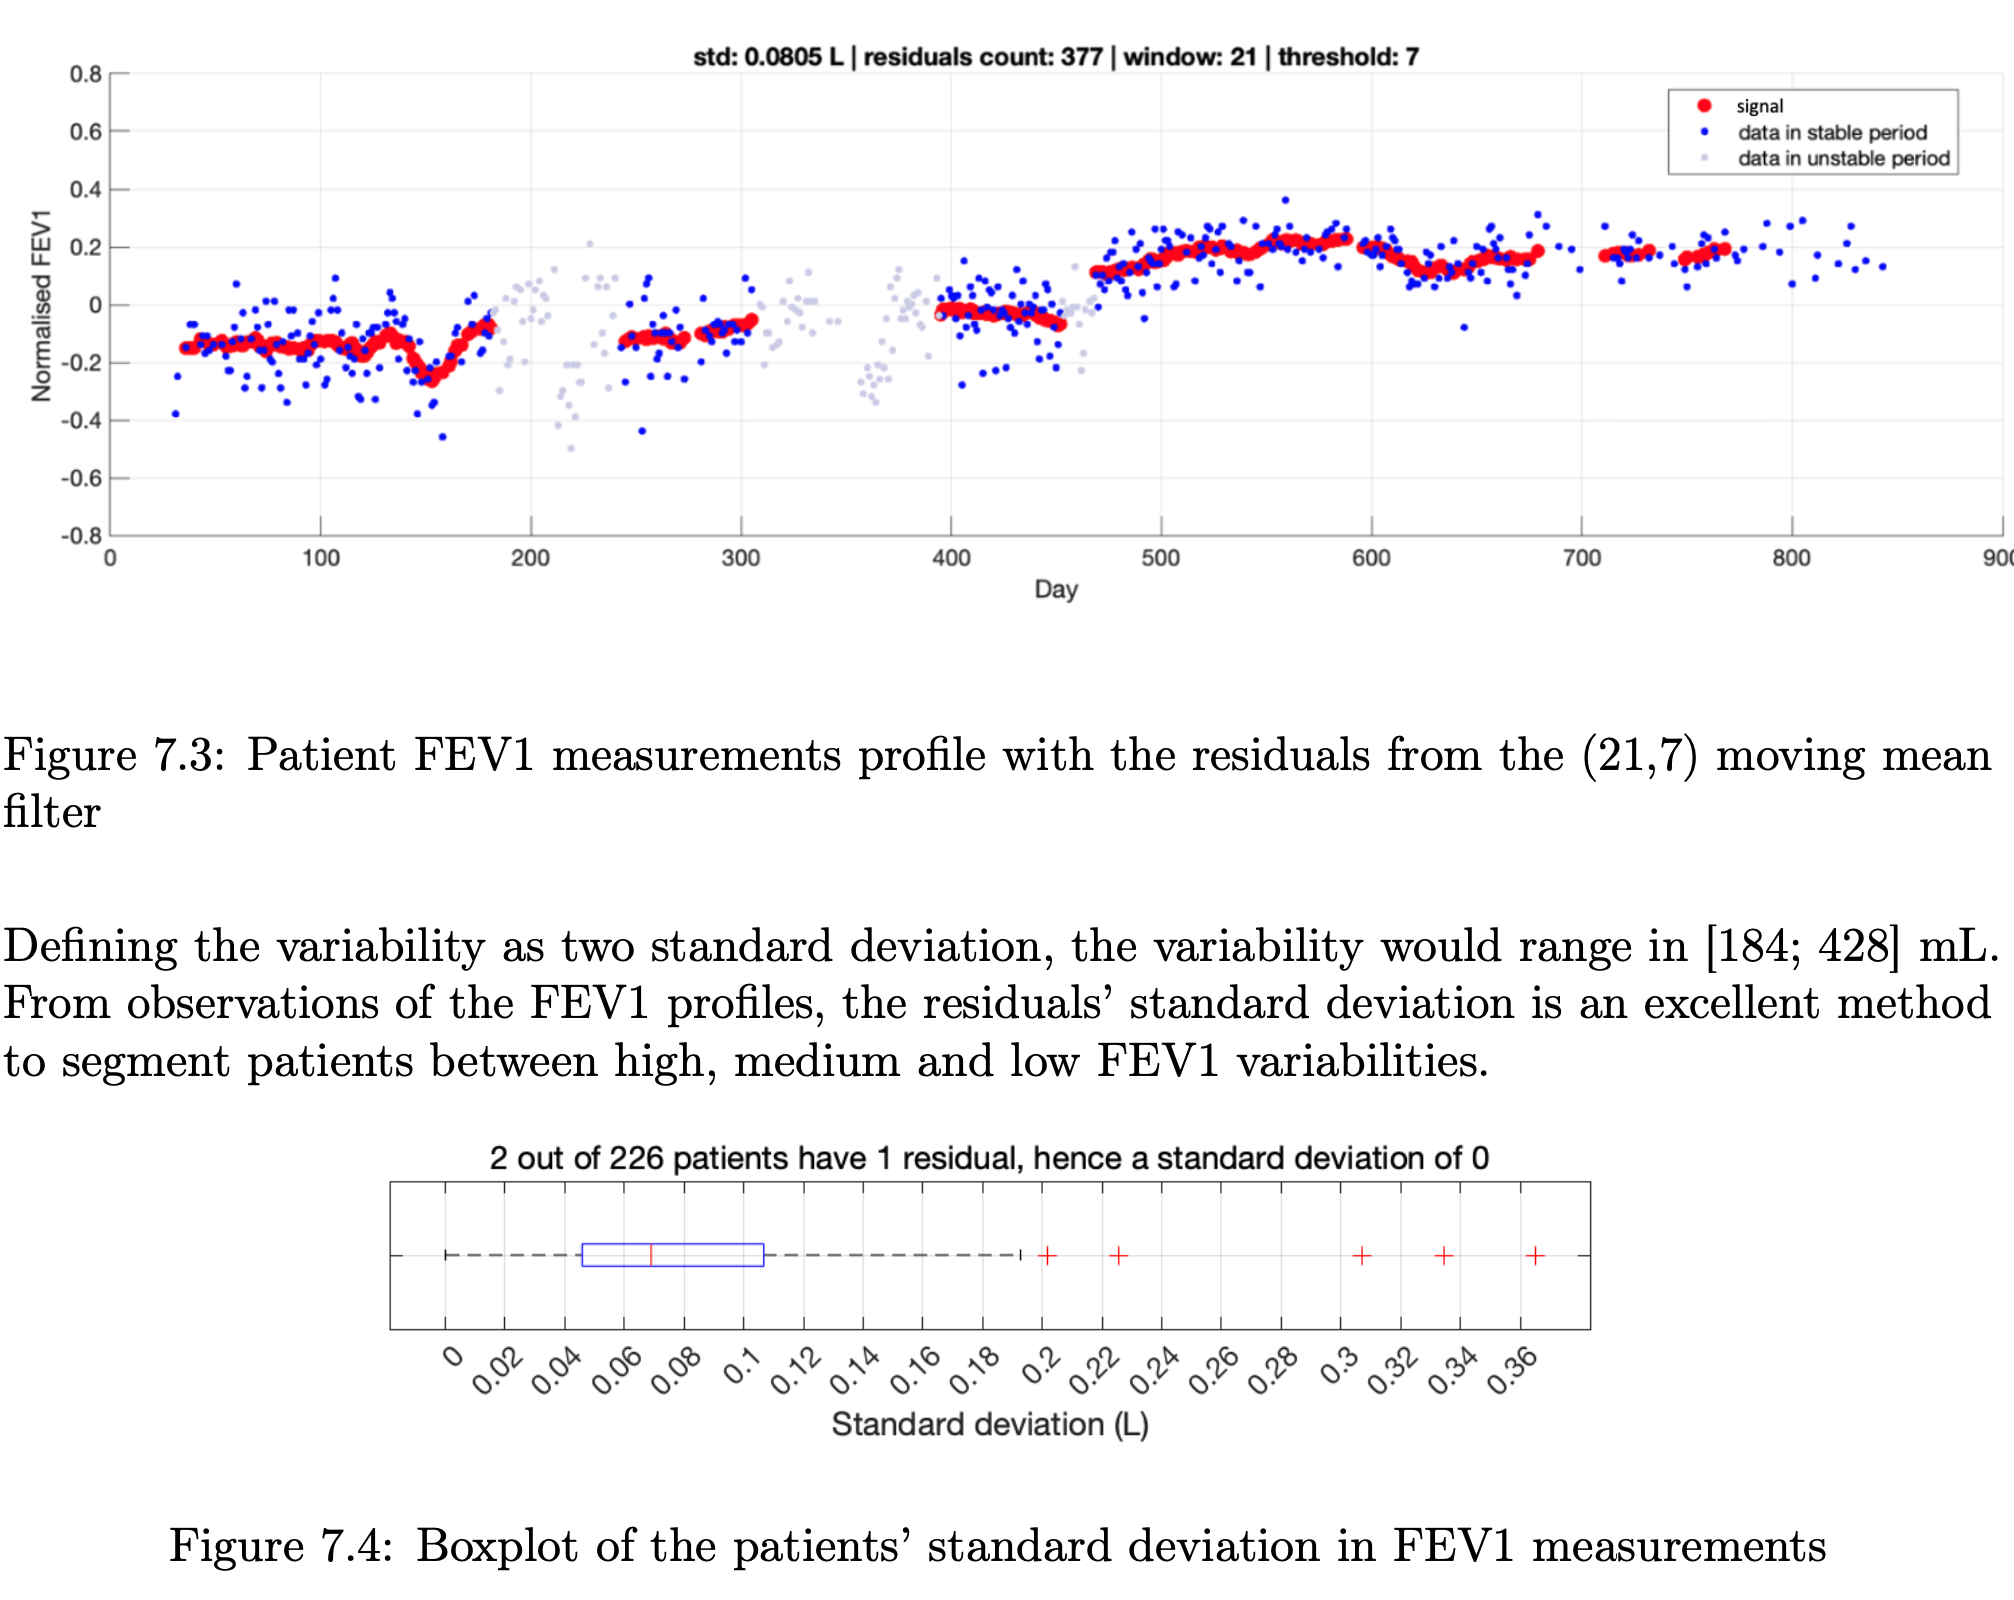

In [527]:
ecFEV1 = mh.VariableNode("ecFEV1 (L)", 0, 6, 0.05, prior={"type": "uniform"})
uecFEV1 = mh.VariableNode("Underlying ecFEV1 (L)", 0, 6, 0.05, prior=None)
# std_gauss = 0.3
# median std gauss is 0.068

# Plot the PDF of ecFEV1 given the middle bin of uecFEV1
uecfev1_bin = uecFEV1.get_bins_arr()[uecFEV1.card // 2]
print("uecFEV1 bin", uecfev1_bin)
# Get the PDF
pdf = np.zeros(ecFEV1.card)
for i, z in enumerate(ecFEV1.midbins):
    pdf[i] = uecfev1.PDF_conv_uni_gausian(z, uecfev1_bin[0], uecfev1_bin[1], std_gauss)
# Norm the pdf
pdf /= np.sum(pdf)
# Plot pdf with graph objects library
fig = go.Figure()
fig.add_trace(go.Bar(x=ecFEV1.midbins, y=pdf))
title = f"P(ecFEV1 | uecFEV1={uecfev1_bin} L)"
fig.update_layout(title=title, height=300, width=650)
fig.update_xaxes(title_text=ecFEV1.name)
fig.show()

uecFEV1 bin [3.   3.05]


## Compute std gauss in accordance to data

### Boxplot of individul level std

In [528]:
# Pick healthy individuals
def get_std(df):
    """
    If there are more than 10 values, compute the standard deviation
    Else, return NaN
    """
    if len(df) > 10:
        return df.std()
    else:
        return np.nan


# Remove unhealthy individuals
# Compute avg predicted fev1 per id
stmp = df.groupby("ID")["ecFEV1 % Predicted"].agg("mean").sort_values()
ids_healthy = stmp[stmp > 80].index

# Filter healthy individuals
df_std = df[df["ID"].isin(ids_healthy)]
stds = df_std.groupby("ID")["ecFEV1"].agg(get_std).dropna().sort_values()

# Print avg std
print(f"Average std: {stds.mean()}")
print(f"Median std: {stds.median()}")

# Plost histogram of stds
fig = px.box(stds, x="ecFEV1", orientation="h")
# Improve boxplot colouring
# More x axis ticks
fig.update_xaxes(tick0=0, dtick=0.05)
# fig = px.histogram(stds, nbins=80)  # , marginal="box")
# Update x axis
# fig.update_xaxes(
#     title_text=f"Standard deviation of the individual's<br> O2 saturation measurements"
# )
# fig.update_yaxes(title_text="Individuals count")
fig.update_layout(
    title_text=f"Distribution of individual-level std ({len(stds)} individuals)",
    height=180,
    width=500,
    showlegend=False,
    font=dict(size=9),
    plot_bgcolor="white",
)
# Grey grid
fig.update_xaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor="lightgrey",
    linecolor="black",
    linewidth=1,
    mirror=True,
    title="ecFEV1 std",
)
# Same on y
fig.update_yaxes(linecolor="black", linewidth=1, mirror=True)
fig.show()

# Median std: 0.1

Average std: 0.15913794855566443
Median std: 0.12954436014298853


### Implement FEV1 variability model

Model from the msc thesis: noise = measurement - signal

In [7]:
# Load data
df_ma = bd.load_meas_from_excel("BR_O2_FEV1_FEF2575_conservative_smoothing_with_idx_MA_31_7")

In [ ]:
# Noise model
w = 31
t = 7

def moving_average_for_ID(df, w, t):
    def moving_average(row, w, t):
        """
        Compute the moving average of an array with window w and threshold t
        """
        date = row['Date Recorded']
        n_days_ago = date - pd.Timedelta(days=(w-1)/2)
        n_days_later = date + pd.Timedelta(days=(w-1)/2)
        # Get the values within the window
        df_ma = df.loc[:, ['Date Recorded', 'ecFEV1']][(df['Date Recorded'] >= n_days_ago) & (df['Date Recorded'] <= n_days_later)]
        # If there are more than t values, compute average of t closest values
        if len(df_ma) > t:
            # Compute number of days reference on the date
            df_ma['N days away'] = (df_ma['Date Recorded'] - date).abs()
            # Sort by the absolute value of the days away
            df_ma = df_ma.sort_values('N days away')
            # Take mean of first t values
            return df_ma['ecFEV1'].head(t).mean()
        else:
            return np.nan
    # Compute moving average
    df['Moving average'] = df.apply(moving_average, args=(w, t), axis=1)
    return df

df_out = df.groupby("ID").apply(lambda df: moving_average_for_ID(df, w, t))
df_out = df_out.drop(columns=['ID']).reset_index().drop(columns=['level_1'])

In [671]:
# # Save df
# df_out.to_excel(f"{dh.get_path_to_main()}ExcelFiles/BR/BR_O2_FEV1_FEF2575_conservative_smoothing_with_idx_MA_{w}_{t}.xlsx", index=False)

In [10]:
# using plotly go, plot scatter of initiall values and moving average

for id in df_ma['ID'].unique():
    dftmp = df_ma[df_ma['ID'] == id]
    df_smoothed = dftmp.dropna(subset=['Moving average'])
    df_isna = dftmp[dftmp['Moving average'].isna()]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dftmp['Date Recorded'], y=dftmp['Moving average'], mode='markers', name='Moving average'))
    fig.add_trace(go.Scatter(x=df_smoothed['Date Recorded'], y=df_smoothed['ecFEV1'], mode='markers', name='Initial ecFEV1 values'))
    fig.add_trace(go.Scatter(x=df_isna['Date Recorded'], y=df_isna['ecFEV1'], mode='markers', name='Values excluded from the moving average'))
    for trace in fig.data:
        if trace.name == 'Moving average':
            trace.marker.color = 'red'
            trace.marker.size = 6
        elif trace.name == 'Values excluded from the moving average':
            trace.marker.color = 'grey'
            trace.marker.size = 3
        elif trace.name == 'Initial ecFEV1 values':
            trace.marker.color = 'blue'
            trace.marker.size = 3
    title = f"{id} - Moving average of ecFEV1 with window {w} and threshold {t}"
    fig.update_layout(title=title, xaxis_title='Date', yaxis_title='ecFEV1 (L)', width=1600, height=500, font=dict(size=16))
    fig.write_image(f"{dh.get_path_to_main()}PlotsBreathe/FEV1_modelling/Moving averages/{title}.pdf")

### How wrong is the additive std gauss?

#### Overall plot

In [531]:
# Create scatter plot
fig = px.scatter(
    df_std,
    x="Mean ecFEV1",
    y="individual-level std<br>of ecFEV1 measurement",
    title=title,
)


# Update x-axis and y-axis properties
fig.update_xaxes(
    title_text="Mean ecFEV1 for individual (L)",
    range=[0, 6],
    showgrid=True,
    gridwidth=1,
    gridcolor="lightgrey",
    linecolor="black",
    mirror=True,
)
fig.update_yaxes(
    showgrid=True, gridwidth=1, gridcolor="lightgrey", linecolor="black", mirror=True
)

# Update marker size and layout
fig.update_traces(marker=dict(size=4))
fig.update_layout(plot_bgcolor="white", width=600, height=450)

# Show the figure
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['ID', 'Date Recorded', 'FEV1', 'O2 Saturation', 'FEF2575', 'ecFEV1', 'ecFEF2575', 'Sex', 'Height', 'Age', 'Predicted FEV1', 'Healthy O2 Saturation', 'ecFEV1 % Predicted', 'FEV1 % Predicted', 'O2 Saturation % Healthy', 'ecFEF2575%ecFEV1', 'idx ecFEV1 (L)', 'idx O2 saturation (%)', 'idx ecFEF2575%ecFEV1', 'idx ecFEF25-75 % ecFEV1 (%)'] but received: Mean ecFEV1

#### Stratify by different FEV1 levels, and check the avg std

In [514]:
stmp = df.groupby("ID")["ecFEV1 % Predicted"].agg("mean").sort_values()

# Remove unhealthy individuals
health_threshold = 0
ids_healthy = stmp[stmp > health_threshold].index
df1 = df[df.ID.isin(ids_healthy)]

# Remove individuals with less than 10 measurements
df1 = df1.groupby("ID").filter(lambda x: len(x) > 10)

# Cut the data in 3 bins of FEV1 values between 0 and 6
min = np.floor(df1.ecFEV1.min() * 10) / 10
max = np.ceil(df1.ecFEV1.max() * 10) / 10
bins = [min, 2, 3, max]
cat1 = f"[{bins[0]}; {bins[1]}) L"
cat2 = f"[{bins[1]}; {bins[2]}) L"
cat3 = f"[{bins[2]}; {bins[3]}) L"
cat1_midbin = (bins[0] + bins[1]) / 2
cat2_midbin = (bins[1] + bins[2]) / 2
cat3_midbin = (bins[2] + bins[3]) / 2

# Create dataframe
s_std = df1.groupby("ID")["ecFEV1"].mean()
df_std = pd.DataFrame(s_std)
# Compute mean of predicted FEV1
df_std["Mean ecFEV1%"] = df1.groupby("ID")["ecFEV1 % Predicted"].mean()
# Rename column
df_std = df_std.rename(columns={"ecFEV1": "Mean ecFEV1"})
# Compute the std for those individuals
df_std["individual-level std<br>of ecFEV1 measurement"] = df1.groupby("ID")[
    "ecFEV1"
].std()
# Cut the avg FEV1 in 3 bins
df_std["ecFEV1 category"] = pd.cut(
    df_std["Mean ecFEV1"], bins, labels=[cat1, cat2, cat3]
)
value_counts = df_std.value_counts("ecFEV1 category")
cat1_val = f"{cat1}<br>(#{value_counts[cat1]})"
cat2_val = f"{cat2}<br>(#{value_counts[cat2]})"
cat3_val = f"{cat3}<br>(#{value_counts[cat3]})"
# Rename the bins in ecFEV1 category
df_std["ecFEV1 category"] = df_std["ecFEV1 category"].replace(
    {cat1: cat1_val, cat2: cat2_val, cat3: cat3_val}
)

# Using px plot boxplots for each category
# fig = px.box(dftmp, x="ecFEV1 category", y="ecFEV1", color="ecFEV1 category", title="ecFEV1 distribution per FEV1 category")
title = f"How wrong is the additive std for ecFEV1?<br>(individuals with {health_threshold}%+ avg predicted FEV1)"
fig = px.box(
    df_std,
    x="ecFEV1 category",
    y="individual-level std<br>of ecFEV1 measurement",
    color="ecFEV1 category",
    title=title,
)

# Enforce cat order on plot
fig.update_xaxes(categoryorder="array", categoryarray=[cat1_val, cat2_val, cat3_val])
# Apply colors to cat1_val in red
for i in range(3):
    if fig.data[i].name == cat1_val:
        fig.data[i].marker.color = "#EF553B"
    elif fig.data[i].name == cat2_val:
        fig.data[i].marker.color = "#AB63FA"
    elif fig.data[i].name == cat3_val:
        fig.data[i].marker.color = "#636EFA"
    else:
        fig.data[i].marker.color = "#00CC96"


# Hide legend
fig.update_layout(showlegend=False, width=500, height=400)
fig.show()
# Write image
fig.write_image(f"{dh.get_path_to_main()}PlotsBreathe/FEV1_modelling/{title}.pdf")

In [513]:
# Same within 1 individual
df1 = df1[df1.ID == "108"]

# Cut the data in 3 bins of FEV1 values between 0 and 6
min = np.floor(df1.ecFEV1.min() * 10) / 10
max = np.ceil(df1.ecFEV1.max() * 10) / 10
bins = [min, 2, max]
print(bins)
cat1 = f"[{bins[0]}; {bins[1]}) L"
cat2 = f"[{bins[1]}; {bins[2]}) L"
# cat3 = f"[{bins[2]}; {bins[3]}) L"
cat1_midbin = (bins[0] + bins[1]) / 2
cat2_midbin = (bins[1] + bins[2]) / 2
# cat3_midbin = (bins[2] + bins[3]) / 2

# Create dataframe
s_std = df1.groupby("ID")["ecFEV1"].mean()
df_std = pd.DataFrame(s_std)
# Compute mean of predicted FEV1
df_std["Mean ecFEV1%"] = df1.groupby("ID")["ecFEV1 % Predicted"].mean()
# Rename column
df_std = df_std.rename(columns={"ecFEV1": "Mean ecFEV1"})
# Compute the std for those individuals
df_std["individual-level std<br>of ecFEV1 measurement"] = df1.groupby("ID")[
    "ecFEV1"
].std()
# Cut the avg FEV1 in 3 bins
df_std["ecFEV1 category"] = pd.cut(df_std["Mean ecFEV1"], bins, labels=[cat1, cat2])
value_counts = df_std.value_counts("ecFEV1 category")
cat1_val = f"{cat1}<br>(#{value_counts[cat1]})"
cat2_val = f"{cat2}<br>(#{value_counts[cat2]})"
# cat3_val = f"{cat3}<br>(#{value_counts[cat3]})"
# Rename the bins in ecFEV1 category
df_std["ecFEV1 category"] = df_std["ecFEV1 category"].replace(
    {cat1: cat1_val, cat2: cat2_val}
)

# Using px plot boxplots for each category
# fig = px.box(dftmp, x="ecFEV1 category", y="ecFEV1", color="ecFEV1 category", title="ecFEV1 distribution per FEV1 category")
title = f"How wrong is the additive std for ecFEV1?<br>(individuals with {health_threshold}%+ avg predicted FEV1)"
fig = px.box(
    df_std,
    x="ecFEV1 category",
    y="individual-level std<br>of ecFEV1 measurement",
    color="ecFEV1 category",
    title=title,
)

# Enforce cat order on plot
fig.update_xaxes(categoryorder="array", categoryarray=[cat1_val, cat2_val])
# Apply colors to cat1_val in red
for i in range(2):
    if fig.data[i].name == cat1_val:
        fig.data[i].marker.color = "#EF553B"
    elif fig.data[i].name == cat2_val:
        fig.data[i].marker.color = "#AB63FA"


# Hide legend
fig.update_layout(showlegend=False, width=500, height=400)
fig.show()
# Write image
fig.write_image(f"{dh.get_path_to_main()}PlotsBreathe/FEV1_modelling/{title}.pdf")

[1.4, 2, 2.8]


IndexError: tuple index out of range

In [512]:
df_std

,Mean ecFEV1,Mean ecFEV1%,individual-level std<br>of ecFEV1 measurement,ecFEV1 category
ID,,,,
108,2.098789,51.337166,0.400537,[2; 2.8) L<br>(#1)


In [470]:
stmp = df.groupby("ID")["ecFEV1 % Predicted"].agg("mean").sort_values()

# Remove unhealthy individuals
health_threshold = 80
ids_healthy = stmp[stmp > health_threshold].index
df1 = df[df.ID.isin(ids_healthy)]

# Remove individuals with less than 10 measurements
df1 = df1.groupby("ID").filter(lambda x: len(x) > 10)

# Cut the data in 3 bins of FEV1 values between 0 and 6
min = np.floor(df1.ecFEV1.min() * 10) / 10
max = np.ceil(df1.ecFEV1.max() * 10) / 10
bins = [min, 2.5, 3, 4, max]
cat1 = f"[{bins[0]}; {bins[1]}) L"
cat2 = f"[{bins[1]}; {bins[2]}) L"
cat3 = f"[{bins[2]}; {bins[3]}) L"
cat4 = f"[{bins[3]}; {bins[4]}) L"
cat1_midbin = (bins[0] + bins[1]) / 2
cat2_midbin = (bins[1] + bins[2]) / 2
cat3_midbin = (bins[2] + bins[3]) / 2
cat4_midbin = (bins[3] + bins[4]) / 2

# Create dataframe
s_std = df1.groupby("ID")["ecFEV1"].mean()
df_std = pd.DataFrame(s_std)
# Compute the std for those individuals
df_std["individual-level std<br>of ecFEV1 measurement"] = df1.groupby("ID")[
    "ecFEV1"
].std()
# Cut the avg FEV1 in 3 bins
df_std["ecFEV1 category"] = pd.cut(
    df_std["ecFEV1"], bins, labels=[cat1, cat2, cat3, cat4]
)
value_counts = df_std.value_counts("ecFEV1 category")
cat1_val = f"{cat1}<br>(#{value_counts[cat1]})"
cat2_val = f"{cat2}<br>(#{value_counts[cat2]})"
cat3_val = f"{cat3}<br>(#{value_counts[cat3]})"
cat4_val = f"{cat4}<br>(#{value_counts[cat4]})"
# Rename the bins in ecFEV1 category
df_std["ecFEV1 category"] = df_std["ecFEV1 category"].replace(
    {cat1: cat1_val, cat2: cat2_val, cat3: cat3_val, cat4: cat4_val}
)

# Using px plot boxplots for each category
# fig = px.box(dftmp, x="ecFEV1 category", y="ecFEV1", color="ecFEV1 category", title="ecFEV1 distribution per FEV1 category")
title = f"How wrong is the additive std for ecFEV1?<br>(individuals with {health_threshold}%+ avg predicted FEV1)"
fig = px.box(
    df_std,
    x="ecFEV1 category",
    y="individual-level std<br>of ecFEV1 measurement",
    color="ecFEV1 category",
    title=title,
)

# Enforce cat order on plot
fig.update_xaxes(
    categoryorder="array", categoryarray=[cat1_val, cat2_val, cat3_val, cat4_val]
)
# Apply colors to cat1_val in red
for i in range(4):
    if fig.data[i].name == cat1_val:
        fig.data[i].marker.color = "#EF553B"
    elif fig.data[i].name == cat2_val:
        fig.data[i].marker.color = "#AB63FA"
    elif fig.data[i].name == cat3_val:
        fig.data[i].marker.color = "#636EFA"
    else:
        fig.data[i].marker.color = "#00CC96"


# Hide legend
fig.update_layout(showlegend=False, width=500, height=400)
fig.show()
# Write image
fig.write_image(f"{dh.get_path_to_main()}PlotsBreathe/FEV1_modelling/{title}.pdf")

In [476]:
# Compute median of stds for each category
s_stds = df_std.groupby("ecFEV1 category")[
    "individual-level std<br>of ecFEV1 measurement"
].agg("median")
df_cats = pd.DataFrame(s_stds)
# Rename col to "Median ..."
median_col = "Median individual-level std<br>of ecFEV1 measurements"
df_cats.columns = [median_col]
# Compute 0.25 percentile and 0.75 percentile
df_cats["Q1"] = df_std.groupby("ecFEV1 category")[
    "individual-level std<br>of ecFEV1 measurement"
].agg(lambda x: np.percentile(x, 25))
df_cats["Q3"] = df_std.groupby("ecFEV1 category")[
    "individual-level std<br>of ecFEV1 measurement"
].agg(lambda x: np.percentile(x, 75))
# Compute Q1
df_cats["Q1 err"] = df_cats[median_col] - df_cats["Q1"]
# Compute Q3
df_cats["Q3 err"] = df_cats["Q3"] - df_cats[median_col]
df_cats.reset_index(inplace=True)

# Compute trendline
import statsmodels.api as sm

# Add category midbins
df_cats["ecFEV1 category midbin"] = [cat1_midbin, cat2_midbin, cat3_midbin]
# df_cats["ecFEV1 category midbin"] = [cat1_midbin, cat2_midbin, cat3_midbin, cat4_midbin]

# Fit a trendline using statsmodels
X = sm.add_constant(df_cats["ecFEV1 category midbin"])
model = sm.OLS(df_cats[median_col], X).fit()
df_cats["trendline"] = model.predict(X)

# Scatter plot with median of stds
title = "Individual-level std of ecFEV1 measurements"
fig = px.scatter(
    df_cats,
    x="ecFEV1 category midbin",
    y=median_col,
    color="ecFEV1 category",
    title=title,
    error_y="Q3 err",
    error_y_minus="Q1 err",
)
# Use same color for scatter plot
for i in range(3):
    # for i in range(4):
    fig.data[i].marker.color = "#636EFA"
fig.add_traces(
    px.line(df_cats, x="ecFEV1 category midbin", y="trendline")
    .update_traces(line=dict(color="black", dash="dot"))
    .data
)

# Replace x axis labels by ecFEV1 category
fig.update_xaxes(
    title_text="ecFEV1 (L)",
    tickvals=df_cats["ecFEV1 category midbin"],
    ticktext=df_cats["ecFEV1 category"],
)
# X range from min ecfev1 in df to max ecfev1 in df
fig.update_xaxes(range=[min, max])
# Remove legend
fig.update_layout(showlegend=False, width=650, height=400)
fig.show()
df_cats

/var/folders/zq/v2r6yn111s3gpdf8lzf72xvw0000gn/T/ipykernel_72130/1034347284.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/zq/v2r6yn111s3gpdf8lzf72xvw0000gn/T/ipykernel_72130/1034347284.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/zq/v2r6yn111s3gpdf8lzf72xvw0000gn/T/ipykernel_72130/1034347284.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,ecFEV1 category,Median individual-level std<br>of ecFEV1 measurements,Q1,Q3,Q1 err,Q3 err,ecFEV1 category midbin,trendline
0,[1.5; 2.5) L<br>(#9),0.090742,0.080125,0.136650,0.010617,0.045908,2.00,0.094439
1,[2.5; 3.5) L<br>(#36),0.121557,0.089008,0.182104,0.032549,0.060547,3.00,0.115748
2,[3.5; 6.0) L<br>(#28),0.150925,0.119276,0.215068,0.031649,0.064143,4.75,0.153038


## Compute CPT with additive (symmetric) gauss noise

In [ ]:
# Wrong: this is the variability beteen 5-95th percentiles
std_gauss = 0.23
# Median std from the variability analysis
std = 0.068

In [39]:
ecFEV1 = mh.VariableNode("ecFEV1 (L)", 0, 6, 0.05, prior={"type": "uniform"})
uecFEV1 = mh.VariableNode("Underlying ecFEV1 (L)", 0, 6, 0.05, prior=None)

# Select bin that's no troubled by borders
uecfev1_bin = uecFEV1.get_bins_arr()[uecFEV1.card // 2]
print("uecFEV1 bin", uecfev1_bin)
# Get the PDF
pdf = np.zeros(ecFEV1.card)
for i, z in enumerate(ecFEV1.midbins):
    pdf[i] = uecfev1.PDF_conv_uni_gausian(z, uecfev1_bin[0], uecfev1_bin[1], std_gauss)
# Norm the pdf
pdf /= np.sum(pdf)

# The same PDF will be shifted across all uecFEV1/ ecFEV1 pairs
# When hitting a border, the PDF will be truncated
cpt = np.zeros((ecFEV1.card, uecFEV1.card))
pdf_peek_idx = uecFEV1.card // 2
for uecFEV1_idx, uecfev1_bin in enumerate(uecFEV1.get_bins_arr()):
    pdf_trunc = np.zeros(len(pdf))
    ecFEV1_idx_peek = uecFEV1_idx
    peek_diff = pdf_peek_idx - ecFEV1_idx_peek
    if peek_diff == 0:
        pdf_trunc = pdf
    elif peek_diff > 0:
        pdf_trunc[0:-peek_diff] = pdf[peek_diff:]
    else:
        pdf_trunc[-peek_diff:] = pdf[:peek_diff]
    # Norm the pdf
    pdf_trunc /= np.sum(pdf_trunc)
    cpt[:, uecFEV1_idx] = pdf_trunc

uecFEV1 bin [3.   3.05]


In [50]:
import src.models.cpts.helpers as cpth
import src.data.helpers as dh

fig, title = cpth.plot_2d_cpt(
    cpt,
    ecFEV1,
    uecFEV1,
    height=6000,
    y_label_two_lines=True,
    p_range=[0, 0.16],
    vspace=0.002,
    invert=False,
)
title = title + f" for an ecFEV1 variability of {std_gauss}"
fig.update_layout(title=title)

fig.write_image(f"{dh.get_path_to_main()}PlotsBreathe/CPTs/{title}.pdf")

In [54]:
cpth.save_cpt([ecFEV1, uecFEV1], cpt, suffix=f"_std_{std_gauss}")

## Compute CPT with multiplicative (asymmetric) gauss noise

## Archive

In [ ]:
# NOTE: THIS IMPLEMENTATION TAKES TOO LONG TO RUN, WHEN WITH ANALYTICAL SOLUTION INSTEAD
def get_noise_model_CPT(
    pVar: mh.VariableNode,
    cVar: mh.VariableNode,
    c_resolution: int,
    std_gauss: float,
    n: int,
    debug=False,
):
    """
    pVar: parent variable, corresponds to the true value that would be obtained for that variable if we had a magic measurement devive
    cVar: child variable, corresponds to the measured value, or a value that could be obtained with a measurement device from clinical practice
    c_resolution: number of decimals, correspond to the resolution of the measurement device
    std_gauss: standard deviation of the gaussian noise of the measurement device
    n: number of samples to generate per bin of the parent variable
    """
    cpt = np.zeros((cVar.card, pVar.card))
    # Do it for one bin that's central,
    # Then shift the values to the other bins

    middle_bin = pVar.get_bins_arr()[pVar.card // 2]
    real_arr = pVar.sample_from_bin(middle_bin, n)
    # Add gaussian noise
    # Truncnorm ensures that sampled values are plausible (within the possible values of the child variable)
    # noisy_real_arr = [truncnorm(cVar.a, cVar.b, loc, std_gauss).rvs(1) for loc in real_arr]
    noisy_real_arr = np.random.normal(real_arr, std_gauss)
    # Round to measurement resolution
    rounded_arr = np.round(noisy_real_arr, c_resolution)
    # Discard values that are out of the possible values of the child variable
    rounded_arr = rounded_arr[(rounded_arr >= cVar.a) & (rounded_arr <= cVar.b)]
    # bin up the rounded values to the child variable
    p_cVar_given_pVar_obs = cVar.bin_up(rounded_arr, normalise=True)

    # # Get
    # # Add to the CPT
    # cpt[:, pVar.card // 2] = p_cVar_given_pVar_obs

    # assert np.isclose(
    #     cpt[:, i].sum(), 1, atol=cVar.tol
    # ), f"The sum of probabilities should be 1, got {cpt[:, i].sum()} while calculating P({cVar.name}|{pVar.name}={pVar_bin})"
    return p_cVar_given_pVar_obs


ecFEV1 = mh.VariableNode("ecFEV1 (L)", 0, 6, 0.05, prior={"type": "uniform"})
uecFEV1 = mh.VariableNode("Underlying ecFEV1 (L)", 0, 6, 0.05, prior=None)
std_gauss = 0.3
n_decimals = 2
n = 100000000

p = get_noise_model_CPT(uecFEV1, ecFEV1, n_decimals, std_gauss, n, debug=False)